In [17]:
import numpy as np
from scipy.linalg import eigh, eig
from scipy.stats import uniform, bernoulli
import itertools
import matplotlib.pyplot as plt

In [57]:
class ErdosRenyiFJ:
    def __init__(self, n, p, w_lower, w_upper, internal_lower, internal_upper):
        assert w_lower >= 0
        assert w_upper >= w_lower
        self.n = n
        upper_triangular_weights = np.triu(uniform.rvs(
            loc=w_lower, scale=w_upper - w_lower, size=[n, n])* bernoulli.rvs(p, size=[n,n]), k=1)
        self.weights = upper_triangular_weights + upper_triangular_weights.T - np.diag(upper_triangular_weights.diagonal())
        self.internal = uniform.rvs(loc=internal_lower, scale=internal_upper - internal_lower, size=n)
        self.expressed = self.internal.copy()

    def __repr__(self):
        return f'weights: \n{self.weights}\ninternal: {self.internal}\nexpressed: {self.expressed}'

    def laplacian(self):
        degree_matrix = np.diag(np.sum(self.weights, axis=1))
        laplacian = degree_matrix - self.weights
        return laplacian

    def disagreement(self):
        disagreement = 0
        for i, j in itertools.product(range(self.n), range(self.n)):
            disagreement += abs(self.weights[i][j]) * (self.expressed[i] - self.expressed[j]) ** 2
        return disagreement

    def polarization(self):
        avg_expressed = np.sum(self.expressed) / self.n
        mean_centered_expressed = self.expressed - avg_expressed
        return np.dot(mean_centered_expressed, mean_centered_expressed)

    def update_weights(self):
        pass

    def run_one_step(self):
        # update_weights have type (self) -> ()
        new_expressed = self.expressed.copy()
        self.expressed = (self.internal + self.weights @ self.expressed) / (1 + np.sum(self.weights, axis=1))
        self.update_weights()
        
    def run_t_steps(self, t):
        for i in range(t):
            self.run_one_step()

In [4]:
class HalvingFJ(ErdosRenyiFJ):
    def __init__(self, n, p, w_lower, w_upper, internal_lower, internal_upper, theta):
        super().__init__(n, p, w_lower, w_upper, internal_lower, internal_upper)
        self.theta = theta
    
    def update_weights(self):
        self.weights = (1 - (np.abs(self.expressed.reshape(-1, 1) - self.expressed) > self.theta) * 1/2) * self.weights

In [5]:
G = ErdosRenyiFJ(300, 0.5, 0, 1, 0, 1)
G.run_t_steps(1000)
print(G)
print(G.disagreement())
print(G.polarization())

weights: 
[[0.         0.91748635 0.66309033 ... 0.         0.51240684 0.90447669]
 [0.         0.         0.         ... 0.03226503 0.         0.        ]
 [0.         0.         0.         ... 0.41312152 0.13000871 0.33836773]
 ...
 [0.         0.         0.09918745 ... 0.         0.06589523 0.62674995]
 [0.         0.50126951 0.         ... 0.02818777 0.         0.        ]
 [0.         0.         0.65883997 ... 0.         0.         0.        ]]
internal: [0.82941066 0.58201274 0.70889421 0.49905073 0.5239591  0.07454705
 0.55395253 0.26943528 0.09536574 0.24340275 0.0701305  0.26537628
 0.84117294 0.93788912 0.94821573 0.88345488 0.01672168 0.66905456
 0.63575729 0.24541273 0.18396879 0.74626643 0.86224571 0.74102022
 0.16751815 0.97417151 0.0046211  0.23996708 0.00545754 0.26697792
 0.84211404 0.76002851 0.50892917 0.97216462 0.69543825 0.25580802
 0.13075232 0.6564549  0.4737787  0.26425078 0.28177532 0.17178761
 0.36548239 0.86630271 0.89283111 0.036592   0.85850471 0.85284712


In [6]:
G = HalvingFJ(10, 0.5, 0, 1, 0, 1, theta=0.2)
G.run_t_steps(1000)
print(G)

weights: 
[[0.00000000e+000 4.98154270e-302 1.07963593e-302 0.00000000e+000
  7.06773418e-302 4.03677652e-302 9.23873181e-001 4.94055065e-001
  0.00000000e+000 6.37035522e-304]
 [4.43236392e-302 0.00000000e+000 5.68198133e-002 8.59380672e-001
  9.25036925e-001 1.95219312e-001 6.66641973e-302 0.00000000e+000
  0.00000000e+000 7.77528351e-001]
 [0.00000000e+000 5.04572508e-001 0.00000000e+000 4.77988772e-001
  0.00000000e+000 0.00000000e+000 0.00000000e+000 2.89070801e-302
  8.98926789e-001 8.66500696e-001]
 [0.00000000e+000 1.09982301e-001 9.55159948e-001 0.00000000e+000
  0.00000000e+000 0.00000000e+000 1.01917113e-300 0.00000000e+000
  4.23853714e-001 8.98694353e-001]
 [9.74125006e-303 3.10659405e-001 0.00000000e+000 1.56545970e-001
  0.00000000e+000 9.83638062e-001 3.10625599e-303 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [1.86902092e-302 3.81020989e-002 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 1.09047509e-302 0.00000000e+000
  4.25042338e-001 1.723

In [7]:
def get_disagreement_polarization_eigenvalues(model, num_steps=1000, num_trials=100):
    disagreements = []
    polarizations = []
    eigenvalues = []
    for trial in range(num_trials):
        G = model()
        G.run_t_steps(num_steps)
        disagreements.append(G.disagreement())
        polarizations.append(G.polarization())
        eigenvalues.append(eigh(G.laplacian(), eigvals_only=True))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials, np.sum(eigenvalues, axis=0) / num_trials

### Basic FJ model on $G_{n,p}$ for $p=\frac12$ where all weights are $w_{ij}$ uniform $[0,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d.

In [8]:
model = lambda: ErdosRenyiFJ(n=300, p=1/2, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1)
get_disagreement_polarization_eigenvalues(model, num_steps=1000, num_trials=10)

(np.float64(0.651626231027171),
 np.float64(0.004394535038240688),
 array([-0.53574745, 57.19690049, 58.14136672, 58.90778   , 59.49182985,
        59.89986166, 60.18389269, 60.51691028, 60.85735245, 61.12529643,
        61.37097969, 61.59248035, 61.7756394 , 61.97081285, 62.2071277 ,
        62.35493248, 62.54808246, 62.68447747, 62.84583162, 63.04119889,
        63.15552489, 63.33316736, 63.48447615, 63.66608475, 63.81239946,
        63.94871534, 64.05172729, 64.19603041, 64.31815988, 64.45430789,
        64.54947654, 64.64729038, 64.76369012, 64.86238339, 64.9797859 ,
        65.0867448 , 65.20779038, 65.31818319, 65.42499612, 65.54539891,
        65.66255043, 65.772123  , 65.88236763, 65.98908697, 66.10366987,
        66.17461461, 66.30578324, 66.3982349 , 66.50947687, 66.60005087,
        66.70257977, 66.78869537, 66.87026112, 66.96344528, 67.06446275,
        67.1611318 , 67.27072244, 67.36249941, 67.45131744, 67.5548782 ,
        67.66099391, 67.73637785, 67.82638431, 67.9133918

### Basic FJ model on $G_{n,p}$ for $p=\frac{1}{n}$ where all weights are $w_{ij}$ uniform $[0,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d.

In [9]:
model = lambda: ErdosRenyiFJ(n=300, p=1/300, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1)
get_disagreement_polarization_eigenvalues(model, num_steps=1000, num_trials=10)

(np.float64(7.532911987480913),
 np.float64(16.557304955949597),
 array([-9.28232403e-01, -8.31895730e-01, -7.47987979e-01, -7.06740718e-01,
        -6.52268580e-01, -6.17284433e-01, -6.03352223e-01, -5.82010098e-01,
        -5.59211280e-01, -5.47372652e-01, -5.26866475e-01, -5.13489585e-01,
        -4.96961176e-01, -4.79644443e-01, -4.67086013e-01, -4.56911575e-01,
        -4.42606763e-01, -4.29557262e-01, -4.18318391e-01, -4.03476793e-01,
        -3.91899482e-01, -3.81683818e-01, -3.67987688e-01, -3.59950026e-01,
        -3.44523782e-01, -3.25533522e-01, -3.06476459e-01, -2.96292234e-01,
        -2.86467199e-01, -2.71680582e-01, -2.60926544e-01, -2.48761400e-01,
        -2.34828045e-01, -2.19276770e-01, -2.09258191e-01, -1.92381640e-01,
        -1.80086165e-01, -1.62154857e-01, -1.50370500e-01, -1.38080188e-01,
        -1.23138125e-01, -1.09619431e-01, -9.96120444e-02, -8.41904712e-02,
        -7.77696957e-02, -6.80628431e-02, -5.67414972e-02, -5.23331798e-02,
        -4.25827492e-02

## Weight Halving Threshold Model with uniform threshold $\theta_{ij} = \theta$

In [61]:
average_disagreements = []
average_polarizations = []
average_eigenvalues = []
thetas = np.linspace(0,1,num=101)
for theta in thetas:
    model = lambda: HalvingFJ(n=300, p=1/2, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1, theta=theta)
    average_disagreement, average_polarization, average_eigenvalue = get_disagreement_polarization_eigenvalues(model, num_steps=1000, num_trials=10)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)
    average_eigenvalues.append(average_eigenvalue)

print(average_disagreements)
print(average_polarizations)

[np.float64(3.4999771067949754e-298), np.float64(0.0032256934366512472), np.float64(0.8819781340195487), np.float64(0.7609562157383823), np.float64(0.7309989523998439), np.float64(0.6906301172167758), np.float64(0.6608955441636998), np.float64(0.6601836113623893), np.float64(0.6815415056258873), np.float64(0.647431791266407), np.float64(0.656025672622101), np.float64(0.6650119651927666), np.float64(0.6537106467366626), np.float64(0.6665527670285366), np.float64(0.6571397414645181), np.float64(0.6404534310938775), np.float64(0.6514907841427003), np.float64(0.6455821167227678), np.float64(0.6481276893121395), np.float64(0.6513824863028503), np.float64(0.6412552062098955), np.float64(0.6534771655422281), np.float64(0.6577945064213784), np.float64(0.6575231468706977), np.float64(0.65290889004255), np.float64(0.6571199195295828), np.float64(0.6595083682563951), np.float64(0.660477001777618), np.float64(0.6634777141330852), np.float64(0.6595947143158635), np.float64(0.6668139968609892), np.f

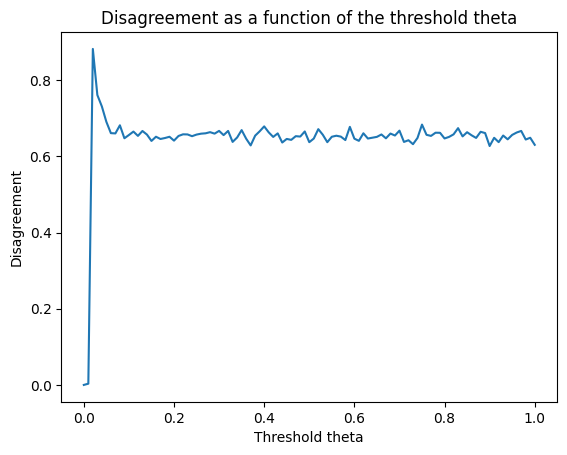

In [62]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the threshold theta')
ax.plot(thetas, average_disagreements)
fig.savefig('threshold_model_halve_weight_disagreement.png')

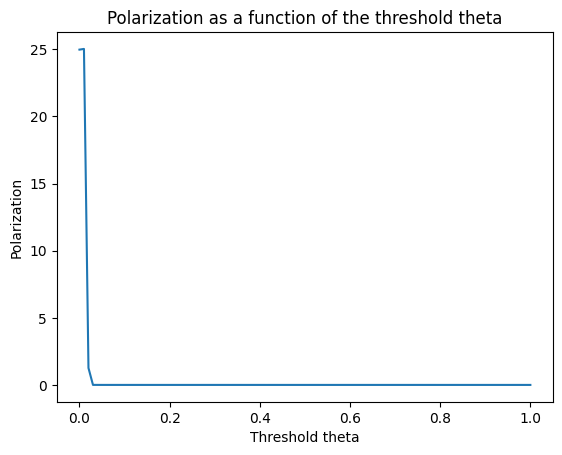

In [63]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the threshold theta')
ax.plot(thetas, average_polarizations)
fig.savefig('threshold_model_halve_weight_polarization.png')

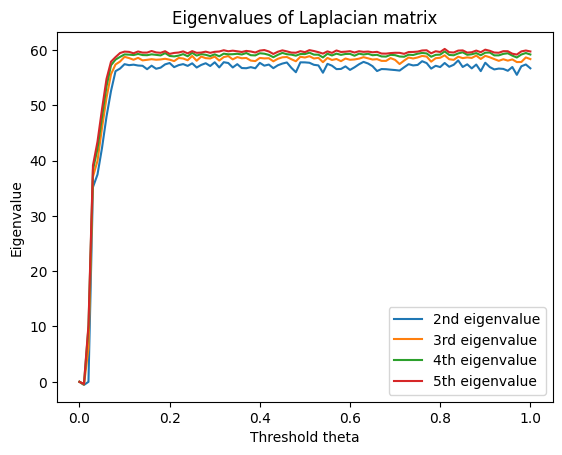

In [67]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Eigenvalue')
ax.set_title('Eigenvalues of Laplacian matrix')
ax.plot(thetas, np.array(average_eigenvalues)[:,1], label='2nd eigenvalue')
ax.plot(thetas, np.array(average_eigenvalues)[:,2], label='3rd eigenvalue')
ax.plot(thetas, np.array(average_eigenvalues)[:,3], label='4th eigenvalue')
ax.plot(thetas, np.array(average_eigenvalues)[:,4], label='5th eigenvalue')
ax.legend()
fig.savefig('threshold_model_halve_weight_polarization.png')

# Trash (To be cleaned)

### Negative weight FJ model on $G_{n,p}$ for $p=\frac12$ where all weights are $w_{ij}$ uniform $[-1,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d. Using sigmoid function to normalize

In [ ]:
from scipy.special import expit

In [ ]:
def run_fj_and_return_expressed_opinions():
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs(loc=-1, scale=2)
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()
    T = 1000
    for t in range(T):
        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = expit(internal_opinions[i] + sum_neighboring_expressed_opinion)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

num_trials = 10
disagreements = []
polarizations = []
for trial in range(num_trials):
    G, opinions = run_fj_and_return_expressed_opinions()
    disagreements.append(disagreement(G, opinions))
    polarizations.append(polarization(G, opinions))

In [ ]:
np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

### Same setup, but with weight halving threshold model with uniform threshold $\theta_{ij} = \theta$

In [ ]:
import networkx as nx
def run_fj_and_return_expressed_opinions(theta):
    # n = 300
    n = 10
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()

    def update_weights():
        for i, nbrs in G.adj.items():
            for j, eattr in nbrs.items():
                if abs(expressed_opinions[i] - expressed_opinions[j]) >= theta:
                    eattr['weight'] /= 2
    T = 1000
    # T = 2
    for t in range(T):

        # print('-' * 50)
        # print('Before update weights:')
        # for i, nbrs in G.adj.items():
        #     for j, eattr in nbrs.items():
        #         print(i, j, round(eattr['weight'], 5), end=';\t')
        #     print()
            
        update_weights()
        # print('After update weights:')
        # for i, nbrs in G.adj.items():
        #     for j, eattr in nbrs.items():
        #         print(i, j, round(eattr['weight'], 5), end=';\t')
        #     print()

        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

def find_disagreement_and_polarization_given_theta(theta):
    num_trials = 3
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G, opinions = run_fj_and_return_expressed_opinions(theta)
        disagreements.append(disagreement(G, opinions))
        polarizations.append(polarization(G, opinions))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

G, expressed_opinions = run_fj_and_return_expressed_opinions(theta=0.01)
for i, nbrs in G.adj.items():
    for j, eattr in nbrs.items():
        print(i, j, round(eattr['weight'], 5), end=';\t')
    print()

# average_disagreements = []
# average_polarizations = []
# thetas = np.linspace(0,1,num=10)
# for theta in thetas:
#     average_disagreement, average_polarization = find_disagreement_and_polarization_given_theta(theta)
#     average_disagreements.append(average_disagreement)
#     average_polarizations.append(average_polarization)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the threshold theta')
ax.plot(thetas, average_disagreements)
fig.savefig('threshold_model_halve_weight_disagreement.png')

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the threshold theta')
ax.plot(thetas, average_polarizations)
fig.savefig('threshold_model_halve_weight_polarization.png')

### Same thing, but weight increasing by $\delta = 1/10$

In [ ]:
def run_fj_and_return_expressed_opinions(theta):
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()

    delta = 1/10
    def update_weights():
        for i, nbrs in G.adj.items():
            for j, eattr in nbrs.items():
                if abs(expressed_opinions[i] - expressed_opinions[j]) >= theta:
                    eattr['weight'] = min(eattr['weight'] + delta, 1) 
    T = 1000
    for t in range(T):

        update_weights()

        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

def find_disagreement_and_polarization_given_theta(theta):
    num_trials = 3
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G, opinions = run_fj_and_return_expressed_opinions(theta)
        disagreements.append(disagreement(G, opinions))
        polarizations.append(polarization(G, opinions))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

average_disagreements = []
average_polarizations = []
thetas = np.linspace(0,1,num=10)
for theta in thetas:
    average_disagreement, average_polarization = find_disagreement_and_polarization_given_theta(theta)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the threshold theta')
ax.plot(thetas, average_disagreements)
fig.savefig('threshold_model_increase_weight_disagreement.png')

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the threshold theta')
ax.plot(thetas, average_polarizations)
fig.savefig('threshold_model_increase_weight_polarization.png')

### Same thing but using the probabilistic model

In [ ]:
from scipy.stats import bernoulli

In [ ]:
def run_fj_and_return_expressed_opinions(delta):
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()

    def update_weights():
        for i, nbrs in G.adj.items():
            for j, eattr in nbrs.items():
                coin_flip = bernoulli.rvs(abs(expressed_opinions[i] - expressed_opinions[j]))
                if not coin_flip:
                    eattr['weight'] = min(eattr['weight'] + delta, 1) 
                else:
                    eattr['weight'] = max(eattr['weight'] - delta, 0)
                    
    T = 1000
    for t in range(T):

        update_weights()

        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

def find_disagreement_and_polarization_given_delta(delta):
    num_trials = 3
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G, opinions = run_fj_and_return_expressed_opinions(delta)
        disagreements.append(disagreement(G, opinions))
        polarizations.append(polarization(G, opinions))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

average_disagreements = []
average_polarizations = []
deltas = np.linspace(0,0.5,num=10)
for delta in deltas:
    average_disagreement, average_polarization = find_disagreement_and_polarization_given_delta(delta)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Difference delta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the difference delta')
ax.plot(deltas, average_disagreements)
fig.savefig('probabilistic_model_disagreement.png')

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Difference delta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the difference delta')
ax.plot(deltas, average_polarizations)
fig.savefig('probabilistic_model_polarization.png')